# Sample Brain Curves Analysis

This code takes the functions and data used in the main_brainReg_genBrainData.py file to then assess a small sample of those pixels

In [102]:
############# Libaries ###############

import h5py
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import numpy as np
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import math
import time
import itertools
from itertools import product, zip_longest
import pickle
from tqdm import tqdm, trange
from datetime import date

import multiprocess as mp
from multiprocessing import Pool, freeze_support
from multiprocessing import set_start_method

import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
parent = os.path.dirname(os.path.abspath(''))
sys.path.append(parent)
import functools

In [131]:
############# Data Set Options & Hyperparameters ############

add_noise = True          #Add noise to the data beyond what is there naturally
add_mask = True             #Add a mask to the data - this mask eliminates data below a threshold (mas_amplitude)
apply_normalizer = True     #Normalizes the data during the processing step
estimate_offset = True      #Adds an offset to the signal that is estimated
subsection = True           #Looks at a region a sixteenth of the full size
multistart_method = False    #Applies a multistart method for each parameter fitting instance
MB_model = False           #This model incoroporates the normalization and offset to a three parameter fit

# The MB_model does the normalization as part of the algorithm
if MB_model: assert(not apply_normalizer and not estimate_offset)


############## Options for Processing ####################

post_normalize_data = False       #This is used to normalize the parameter estimates after it has been generated

In [104]:
############## Frequently Changed Parameters ###########

n_lambdas = 101

SNR_goal = 100

if add_noise:
    iterations = 200
else:
    iterations = 1

#Order of pixels (left of vc, above vc, white matter towards center, white matter towards periphery)
pixels = np.array([[52,38],[40,62],[40,37],[42,18]])
print(f'Analyzing {pixels.shape[0]} pixels')

Analyzing 4 pixels


In [105]:
############## Initializing Data ##########

brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

if subsection:
    I_raw_x = I_raw.shape[0]//4
    I_raw_y = I_raw.shape[1]//4
    I_raw = I_raw[I_raw_x:2*I_raw_x, I_raw_y:2*I_raw_y, :]

n_vert, n_hori, n_elements_brain = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements_brain)*(t_increment_brain), n_elements_brain)

# #This is how we will keep track of all voxels that are called --------------------------------- no iterator for voxels needed
# target_iterator = np.array([item for item in itertools.product(np.arange(0,n_vert,1), np.arange(0,n_hori,1))])

# all pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 700

############# Global Params ###############

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']
#These bounds were chosen to match the simulated data while also being restrictive enough
#This provides a little extra space as the hard bounds would be [1,1,50,300]
if MB_model:
    upper_bound = [np.inf, 0.5, 60, 2000] #c1 used to be 0.5 - changed to 1 for complete range
elif not apply_normalizer:
    upper_bound = [0.5,1.2,60,2000]
else:
    upper_bound = [0.5,1.2,60,2000]

if estimate_offset or MB_model:
    upper_bound.append(np.inf)

lambdas = np.append(0, np.logspace(-5,1, n_lambdas))

n_pix = pixels.shape[0]
n_lam = lambdas.shape[0]

ob_weight = 1
if MB_model:
    agg_weights = np.array([1/ob_weight, 1, 1/ob_weight, 1/ob_weight])
if not apply_normalizer:
    agg_weights = np.array([1,1,1,1])
else:
    agg_weights = np.array([1, 1, 1/ob_weight, 1/ob_weight])

if multistart_method:
    num_nultistarts = 10
    ms_upper_bound = [1,60,300] 
else:
    num_multistarts = 1
    ms_upper_bound = [0] 

SNR_collect = np.zeros(iterations)

if subsection:
    vert1 = 37
    vert2 = 47
    hori1 = 25
    hori2 = 70
else:
    vert1 = 165             #60     #108
    vert2 = 180            #125     #116
    hori1 = 120            #100      #86
    hori2 = 180            #115      #93

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

In [106]:
############# Signal Functions ##############

def G(t, con_1, con_2, tau_1, tau_2): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2)
    return function

def G_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_MB(t, alpha, beta, tau_1, tau_2, offSet):
    function = alpha*(beta*np.exp(-t/tau_1) + (1-beta)*np.exp(-t/tau_2)) + offSet
    return function

def G_tilde(lam, SA = 1, offSet = estimate_offset, opt_MB = MB_model):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    if offSet:
        def Gt_lam(t, con1, con2, tau1, tau2, oS):
            return np.append(G_off(t, con1, con2, tau1, tau2, oS), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    elif opt_MB:
        def Gt_lam(t, alpha, beta, tau1, tau2, oS):
            return np.append(G_MB(t, alpha, beta, tau1, tau2, oS), [lam*alpha/ob_weight, lam*beta/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    else:
        def Gt_lam(t, con1, con2, tau1, tau2):
            return np.append(G(t, con1, con2, tau1, tau2), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam



In [121]:
############# Result Processing Functions ##############

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,object.shape[-1]))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

def calc_improvement(old, new):
    return (old - new)/old

def calc_improvement_ref(old, new, ref):
    return (old - new)/ref**2

def calc_improvement_diff(old, new):
    return abs(old - new)

In [108]:
############# Data Processing Functions ##############

def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def normalize_brain(I_data):
    n_vert, n_hori, n_elem = I_data.shape
    I_normalized = np.zeros(I_data.shape)
    for i_vert in range(n_hori):
        for i_hori in range(n_vert):
            data = I_data[i_vert,i_hori,:]
            if data[0]>0:
                data_normalized = data/(data[0])
            else:
                data_normalized = np.zeros(n_elements_brain)
            I_normalized[i_vert,i_hori,:] = data_normalized
    return I_normalized

def add_noise_brain_uniform(raw, SNR_desired, region, I_mask_factor):
    #This function was built with the intention of taking a region (e.g. the homogenous region to the right of the ventricles)
    #Add noise to make sure the final SNR is close to the desired SNR

    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    sigRef = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:]
    initSD = np.std(regionEnd)

    addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)

    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat*I_mask_factor

    return I_noised, addSD

In [109]:
################## Parameter Estimation Functions ###############

def generate_p0(ms_ub = ms_upper_bound, offSet = estimate_offset, ms_opt = multistart_method, sig_init = 1):
    
    
    if MB_model:
        init_params = (sig_init, 0.2, 20, 80, 1)
    elif not ms_opt:
        init_params = (sig_init*0.2, sig_init*0.8, 20, 80, 1)
    else:
        three_params = np.random.uniform(0,1,3)*ms_ub
        init_params = (sig_init*three_params[0], sig_init*(1-three_params[0]), three_params[1], three_params[2], 1)

    if not offSet and not MB_model:
        init_params = init_params[0:4] #cleave the 5th parameter

    return init_params

def check_param_order(popt):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[2] > popt[3]): #We want by convention to make sure that T21 is <= T22
        p_hold = popt[0]
        popt[0] = popt[1]
        popt[1] = p_hold

        p_hold = popt[2]
        popt[2] = popt[3]
        popt[3] = p_hold
    return popt

def estimate_parameters(data, lam, n_initials = num_multistarts):
    #Pick n_initials random initial conditions within the bound, and choose the one giving the lowest model-data mismatch residual

    parameter_tail = [0,0,0,0]
    data_tilde = np.append(data, parameter_tail) # Adds zeros to the end of the regularization array for the param estimation
    
    RSS_hold = np.inf
    obj_hold = np.inf
    for i in range(n_initials):

        np.random.seed(i) #Only has an effect on the multistart strategy
        if MB_model or not apply_normalizer:
            init_params = generate_p0(sig_init = data_tilde[0])
        else:
            init_params = generate_p0()

        temp_upper_bound = np.copy(upper_bound)
        if not apply_normalizer and not MB_model:
            temp_upper_bound[0] = data_tilde[0]*upper_bound[0]
            temp_upper_bound[1] = data_tilde[0]*upper_bound[1]
        
        try:
            if estimate_offset or MB_model:
                lower_bound = [0,0,0,0,0]
            else:
                lower_bound = [0,0,0,0]
            popt, _ = curve_fit(G_tilde(lam), tdata, data_tilde, bounds = (lower_bound, temp_upper_bound), p0=init_params, max_nfev = 4000)
        except Exception as error:
            if estimate_offset or MB_model:
                popt = [0,0,1,1,0]
            else:
                popt = [0,0,1,1]
            print("Error in parameter fitting: " + str(error))

        if estimate_offset:
            est_curve = G_off(tdata,*popt)
        elif MB_model:
            est_curve = G_MB(tdata,*popt)
        else:
            est_curve = G(tdata,*popt)
        RSS_temp = np.sum((est_curve - data)**2)

        obj_pTemp = lam*agg_weights*popt[0:4]
        obj_temp = RSS_temp + np.linalg.norm(obj_pTemp)

        if obj_temp < obj_hold:
            obj_hold = obj_temp
            best_popt = popt
            RSS_hold = RSS_temp
        
    if not MB_model:
        popt = check_param_order(best_popt)
    else:
        popt = best_popt
 
    return popt, RSS_hold

def generate_all_estimates(i_vert, i_hori, brain_data_3D):
    #Generates a comprehensive matrix of all parameter estimates for all param combinations, 
    #noise realizations, SNR values, and lambdas of interest

    #This function had to be adjusted to account for individual voxels fed in rather than a list of voxels

    # i_vert, i_hori = target_iterator[i_voxel]--------------------- not used
    noise_data = brain_data_3D[i_vert, i_hori, :]
    assert(noise_data.shape[0] == n_elements_brain)
    
    RSS_list = []
    param_list = []

    for iLam in range(len(lambdas)):    #Loop through all lambda values
        e_df = pd.DataFrame(columns = ["Data", "Indices", "Estimates", "RSS"])
        lam = lambdas[iLam]

        if np.all(noise_data == 0):
            if estimate_offset or MB_model:
                param_estimates = [0,0,1,1,0]
            else:
                param_estimates = [0,0,1,1]
            RSS_estimate = np.inf
        else:
            param_estimates, RSS_estimate = estimate_parameters(noise_data, lam)
        
        param_list.append(param_estimates)
        RSS_list.append(RSS_estimate)

    return param_list, RSS_list

In [110]:
##### Regularization Functions on Stored Data


def get_GCV_value(params, RSS, lamb):

    wmat = np.array([[1,0,0,0],[0,1,0,0],[0,0,0.01,0],[0,0,0,0.01]])
    GCVjacobian = J(tdata, *params)
    C_GCV = GCVjacobian@np.linalg.inv(GCVjacobian.transpose()@GCVjacobian+(lamb**2)*wmat.transpose()@wmat)@GCVjacobian.transpose()
    (n,n) = C_GCV.shape
    identity = np.identity(n)
    GCVdenominator = (identity - C_GCV).trace()
    GCV = RSS/(GCVdenominator**2)
    return GCV

def pull_GCV(est_combos, RSS_combos, lambda_array):

    #GCV only uses the four main parameters and doesn't consider the offset term

    n_pix = est_combos.shape[0]
    
    GCV_hold_values = np.zeros(len(lambda_array))
    GCV_final_lam = np.zeros((n_pix))
    GCV_final_params = np.zeros((n_pix, est_combos.shape[-1]))
    GCV_curves = np.zeros((n_pix, len(lambda_array)))

    for i_pix in range(n_pix): #Loop through all verticle indicies

        count_singular = 0

        for iLam in range(len(lambda_array)):    #Loop through all lambda values
            one_param_combo = est_combos[i_pix, iLam, 0:4]
            one_param_RSS = RSS_combos[i_pix, iLam]
            if lambda_array[iLam] == 0:
                GCV_hold_values[iLam] = np.inf
            else:
                try:
                    GCV_hold_values[iLam] = get_GCV_value(one_param_combo, one_param_RSS, lambda_array[iLam])
                except:
                    GCV_hold_values[iLam] = np.inf
                    count_singular += 1

        min_GCV_index = np.argmin(GCV_hold_values)   
        GCV_final_params[i_pix,:] = est_combos[i_pix, min_GCV_index, :]
        GCV_final_lam[i_pix] = lambda_array[min_GCV_index]
        GCV_curves[i_pix,:] = GCV_hold_values
        
        if count_singular >0:
            print(f"Combo = [{i_pix}] had {count_singular} singular GCV values associated with nonzero lambda values")
    
    return GCV_final_lam, GCV_final_params, GCV_curves

In [111]:
def pull_avgNR(true_combos, est_combos):
    true_combos = np.array(true_combos)
    bias_hold_array = np.zeros(est_combos.shape)
    for iter in range(bias_hold_array.shape[1]):
        bias_hold_array[:,iter,:] = est_combos[:,iter,:] - true_combos[iter, :]
    bias = np.mean(bias_hold_array, axis = 0) #average the bias across all noise realizations
    variance = np.var(est_combos, axis = 0) #obtains the variance across all noise realizations
    return bias, variance

def match_index(index_array, bias, var):
    return_bias = np.zeros(index_array.shape)
    return_var = np.zeros(index_array.shape)
    for iPC in range(index_array.shape[0]):
        if len(index_array.shape)>1:
            for iParam in range(index_array.shape[-1]):
                return_bias[iPC, iParam] = bias[iPC, index_array[iPC, iParam],iParam] 
                return_var[iPC, iParam] = var[iPC, index_array[iPC, iParam],iParam]
        else:
            return_bias[iPC] = bias[iPC, index_array[iPC]] 
            return_var[iPC] = var[iPC, index_array[iPC]]
    return return_bias, return_var

In [112]:
#### This ensures that the same mask is applied throughout

if add_mask:
    I_masked = mask_data(I_raw, mask_amplitude)
    I_mask_factor = (I_masked!=0)
else:
    I_masked = I_raw
    I_mask_factor = (I_masked!=0)

#### Generate the standard reference

if apply_normalizer:
    stand_ref = normalize_brain(I_masked)
else:
    stand_ref = I_masked
SNR_SR = calculate_brain_SNR(stand_ref, noiseRegion)

SR_param_list = []
SR_RSS_list = []

unnoised_curves = np.zeros((n_pix,n_elements_brain))

for pix in range(pixels.shape[0]):
    
    unnoised_curves[pix,:] = stand_ref[pixels[pix,0],pixels[pix,1],:]
    parameter_estimates, RSS_estimates = generate_all_estimates(pixels[pix,0], pixels[pix,1], stand_ref)
    SR_param_list.append(parameter_estimates)
    SR_RSS_list.append(RSS_estimates)

#### Looping through Iterations of the brain - applying parallel processing to improve the speed

iter_param_list = []
iter_RSS_list = []
noised_curves = np.zeros((iterations, n_pix, n_elements_brain))

for iter in trange(iterations):    #Build {iterations} number of noisey brain realizations for each of the test cases

    np.random.seed(iter)

    if add_noise:
        I_noised = add_noise_brain_uniform(I_masked, SNR_goal, noiseRegion, I_mask_factor)[0]
    else:
        I_noised = I_masked

    if apply_normalizer:
        noise_iteration = normalize_brain(I_noised)
    else:
        noise_iteration = I_noised

    SNR_collect[iter] = calculate_brain_SNR(noise_iteration, noiseRegion)


    pixel_param_list = []
    pixel_RSS_list = []

    for pix in range(pixels.shape[0]):
        
        noised_curves[iter, pix, :] = noise_iteration[pixels[pix,0],pixels[pix,1], :]
        parameter_estimates, RSS_estimates = generate_all_estimates(pixels[pix,0], pixels[pix,1], noise_iteration)
        pixel_param_list.append(parameter_estimates)
        pixel_RSS_list.append(RSS_estimates)

    iter_param_list.append(pixel_param_list)
    iter_RSS_list.append(pixel_RSS_list)


100%|██████████| 200/200 [34:59<00:00, 10.50s/it]


In [113]:
iter_param_array = np.array(iter_param_list)
iter_RSS_array = np.array(iter_RSS_list)

SR_param_array = np.array(SR_param_list)
SR_RSS_array = np.array(SR_RSS_list)

print(iter_param_array.shape)
print(iter_RSS_array.shape)

print(SR_param_array.shape)
print(SR_RSS_array.shape)

(200, 4, 102, 5)
(200, 4, 102)
(4, 102, 5)
(4, 102)


In [136]:
if post_normalize_data:
    complete_estimates = post_normalize(iter_param_array)
    SR_complete_estimates = post_normalize(SR_param_array)
    post_norm_blurb = "\nPost Normalized"
    print("Normalized Data")
else:
    print("Raw Data")
    post_norm_blurb = ""
    complete_estimates = iter_param_array
    SR_complete_estimates = SR_param_array

Raw Data


In [137]:
nonreg_sr_params = SR_complete_estimates[:,0,:]
nonreg_est_params = complete_estimates[:,:,0,:]

n_par = complete_estimates.shape[-1]

all_GCV_estimates = np.zeros((iterations, n_pix, n_par))
all_GCV_curves = np.zeros((iterations, n_pix, n_lam))
all_GCV_lambdas = np.zeros((iterations, n_pix))

for iter in range(iterations):

    GCV_lambdas, GCV_estimates, GCV_curves = pull_GCV(complete_estimates[iter,:,:,:], iter_RSS_array[iter,:,:], lambdas)
    all_GCV_estimates[iter,:] = GCV_estimates
    all_GCV_lambdas[iter,:] = GCV_lambdas
    all_GCV_curves[iter,:] = GCV_curves

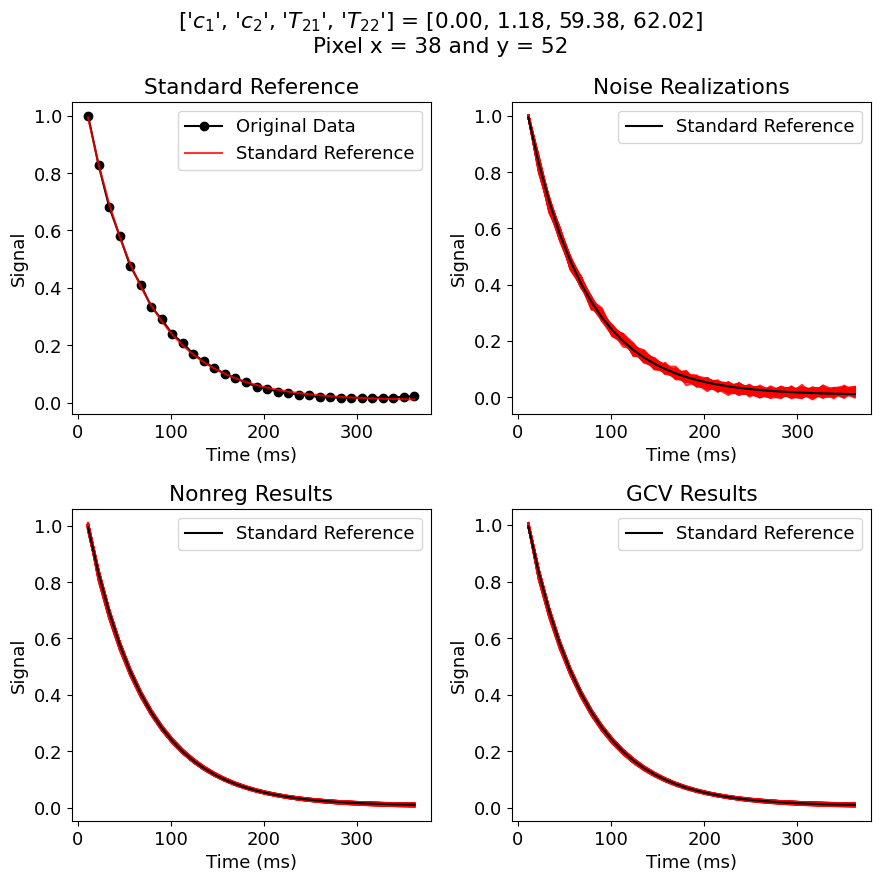

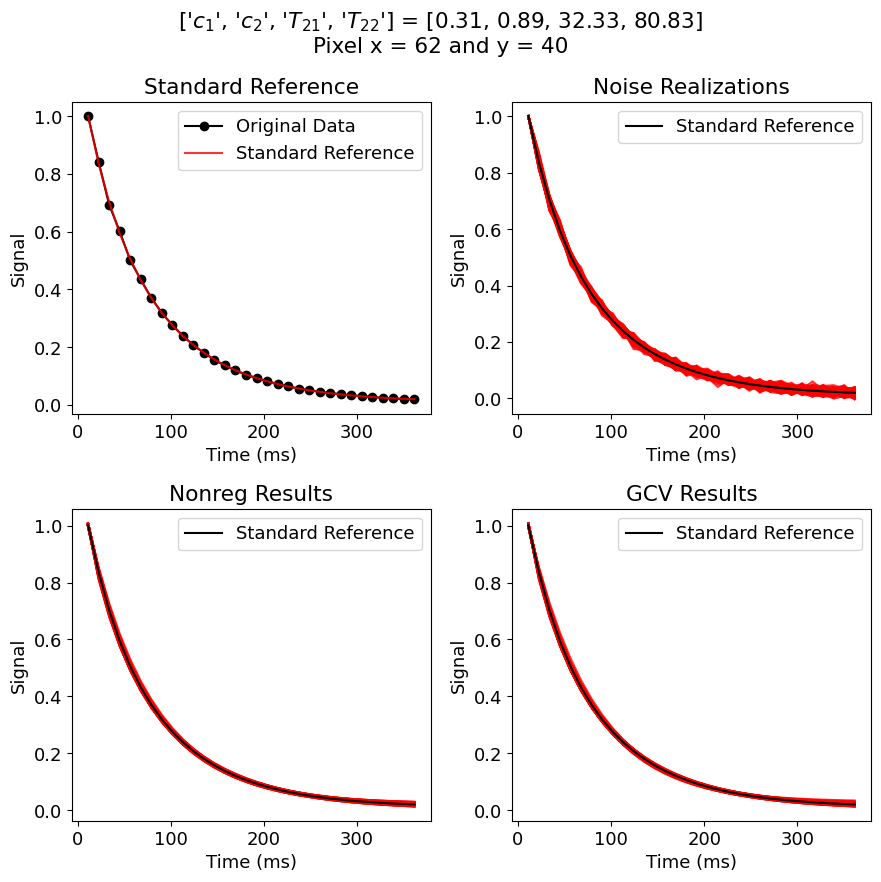

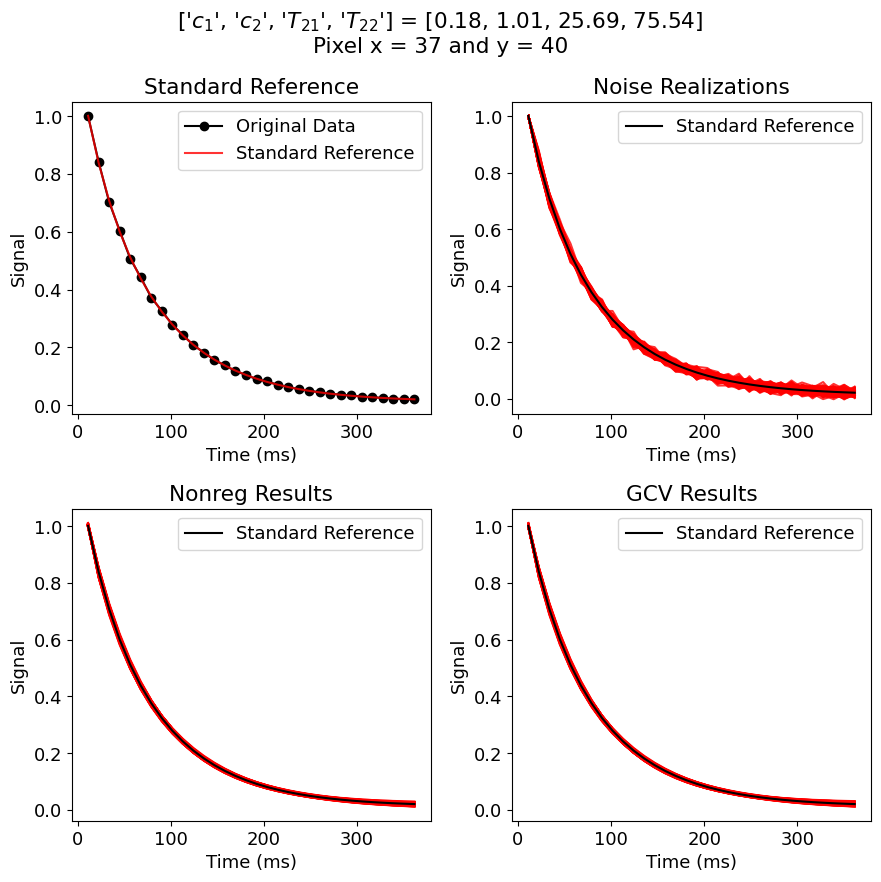

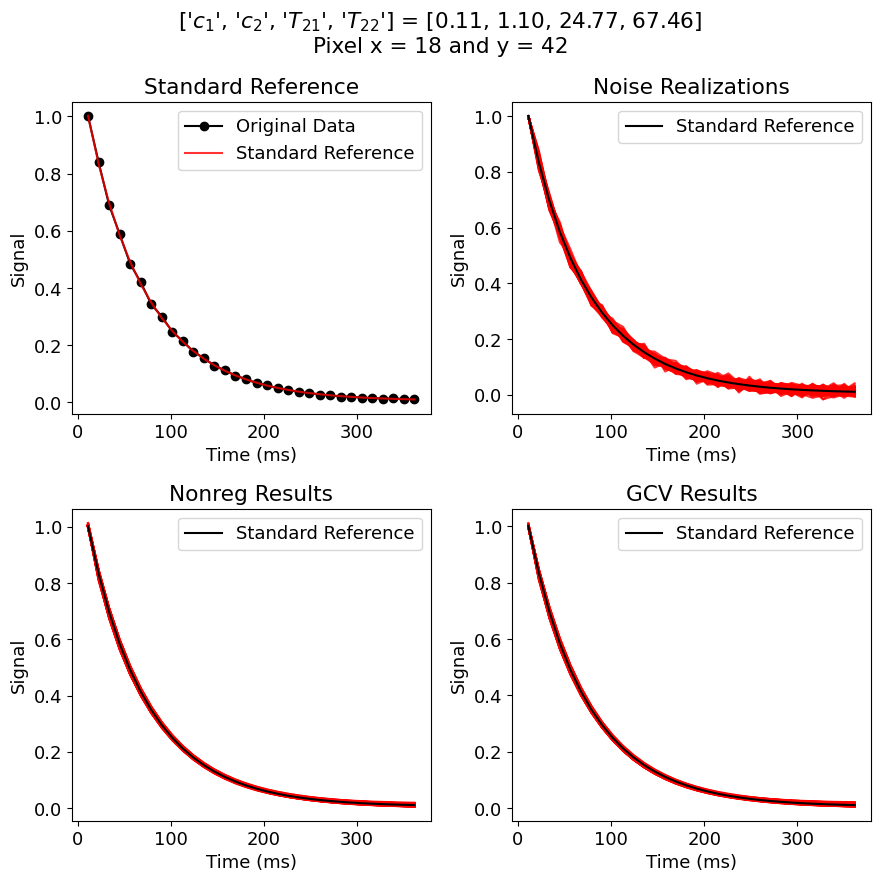

In [144]:
for pix in range(n_pix):
    fig, ax = plt.subplots(2,2,figsize=(9,9),tight_layout=True)
    plt.suptitle(f"{param_name_list} = [{nonreg_sr_params[pix,0]:.2f}, {nonreg_sr_params[pix,1]:.2f}, {nonreg_sr_params[pix,2]:.2f}, {nonreg_sr_params[pix,3]:.2f}]\nPixel x = {pixels[pix,1]} and y = {pixels[pix,0]}")
    ax[0,0].plot(tdata, unnoised_curves[pix,:], color = 'k', label = "Original Data", marker = 'o')
    ax[0,0].plot(tdata, G_off(tdata, *nonreg_sr_params[pix,:]), label = "Standard Reference", alpha = 0.8, ls = "-", color = 'r')
    ax[0,0].set_xlabel('Time (ms)')
    ax[0,0].set_ylabel('Signal')
    ax[0,0].set_title("Standard Reference")
    ax[0,0].legend()

    
    for iter in range(iterations):
        ax[0,1].plot(tdata, noised_curves[iter,pix,:], alpha = 0.8, ls = "-", color = 'r')
    ax[0,1].plot(tdata, G_off(tdata, *nonreg_sr_params[pix,:]), color = 'k', label = "Standard Reference")
    ax[0,1].set_xlabel('Time (ms)')
    ax[0,1].set_ylabel('Signal')
    ax[0,1].set_title("Noise Realizations")
    ax[0,1].legend()

    
    for iter in range(iterations):
        ax[1,0].plot(tdata, G_off(tdata, *nonreg_est_params[iter,pix, :]), alpha = 0.8, ls = "-", color = 'r')
    ax[1,0].plot(tdata, G_off(tdata, *nonreg_sr_params[pix,:]), color = 'k', label = "Standard Reference")
    ax[1,0].set_xlabel('Time (ms)')
    ax[1,0].set_ylabel('Signal')
    ax[1,0].set_title("Nonreg Results")
    ax[1,0].legend()

    
    for iter in range(iterations):
        ax[1,1].plot(tdata, G_off(tdata, *all_GCV_estimates[iter,pix, :]), alpha = 0.8, ls = "-", color = 'r')
    ax[1,1].plot(tdata, G_off(tdata, *nonreg_sr_params[pix,:]), color = 'k', label = "Standard Reference")
    ax[1,1].set_xlabel('Time (ms)')
    ax[1,1].set_ylabel('Signal')
    ax[1,1].set_title("GCV Results")
    ax[1,1].legend()

In [139]:
orcAvg_bias, orcAvg_var = pull_avgNR(nonreg_sr_params, iter_param_array)
orcAvg_MSE = orcAvg_bias**2 + orcAvg_var
orcAvg_agg_MSE = np.sum(orcAvg_MSE[:,:,0:4]*agg_weights**2, axis = -1)
orcAvg_agg_bias_sq = np.sum(orcAvg_bias[:,:,0:4]**2*agg_weights**2, axis = -1)
orcAvg_agg_var = np.sum(orcAvg_var[:,:,0:4]*agg_weights**2, axis = -1)

#Finds the lambda with the best MSE
minMSE_orcAvg_MSE = np.min(orcAvg_MSE, axis = 1)
minMSE_orcAvg_MSE_index = np.argmin(orcAvg_MSE, axis = 1)
minMSE_orcAvg_lamb = lambdas[minMSE_orcAvg_MSE_index]
minMSE_orcAvg_bias, minMSE_orcAvg_var = match_index(minMSE_orcAvg_MSE_index, orcAvg_bias, orcAvg_var)
    

In [140]:
nonreg_bias = orcAvg_bias[:,0,:]
nonreg_var = orcAvg_var[:,0,:]
nonreg_agg_biasSq = np.sum(nonreg_bias[:,0:4]**2*agg_weights**2, axis = -1)
nonreg_agg_var = np.sum(nonreg_var[:,0:4]*agg_weights**2, axis = -1)
nonreg_MSE = orcAvg_MSE[:,0,:]

In [141]:
GCV_bias_hold_array = all_GCV_estimates - nonreg_sr_params
GCV_bias = np.mean(GCV_bias_hold_array, axis = 0) #average the bias across all noise realizations
GCV_var = np.var(all_GCV_estimates, axis = 0) #obtains the variance across all noise realizations
GCV_MSE = GCV_bias**2 + GCV_var

GCV_agg_MSE = np.sum(GCV_MSE[:,0:4]*agg_weights**2, axis = -1)
GCV_agg_bias_sq = np.sum(GCV_bias[:,0:4]**2*agg_weights**2, axis = -1)
GCV_agg_var = np.sum(GCV_var[:,0:4]*agg_weights**2, axis = -1)

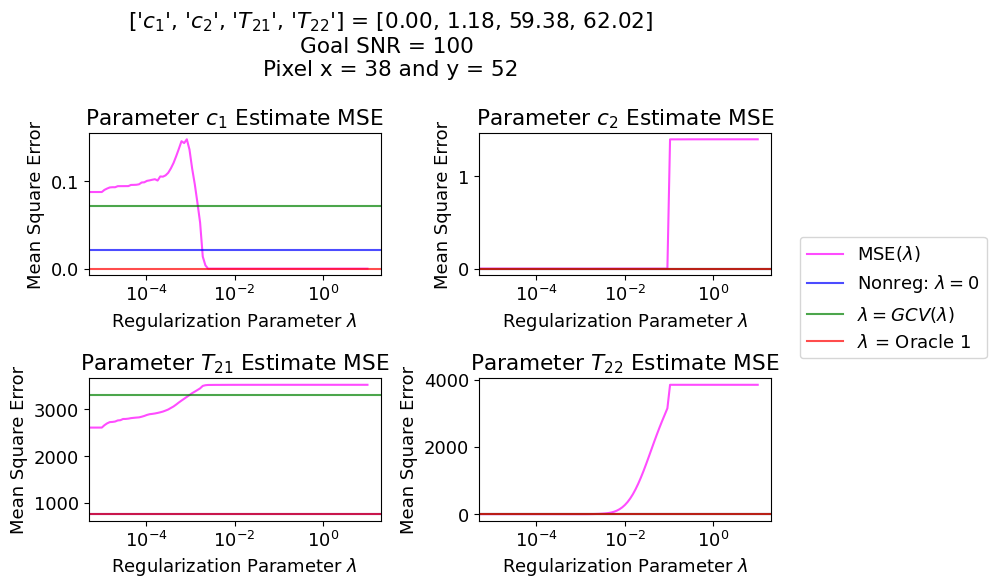

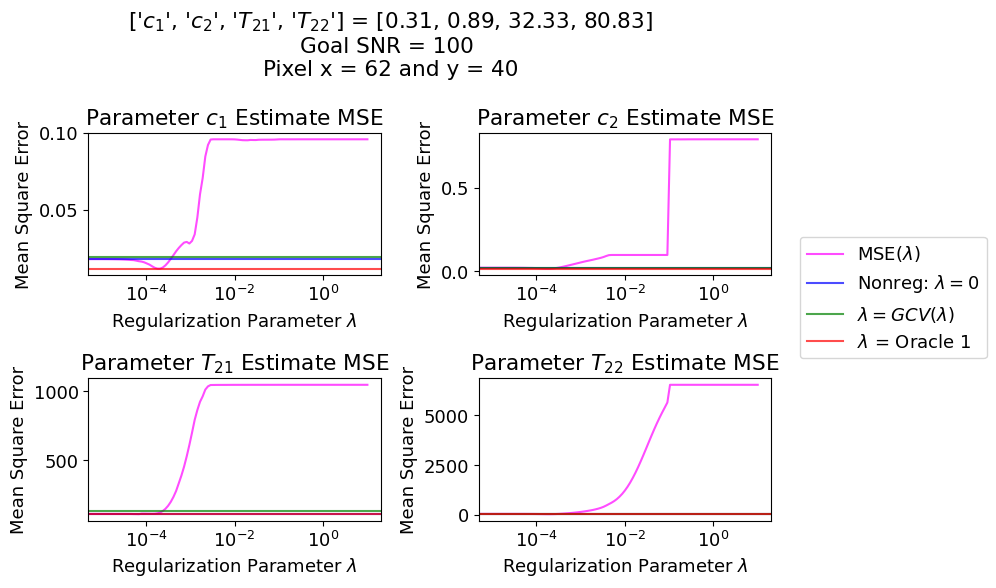

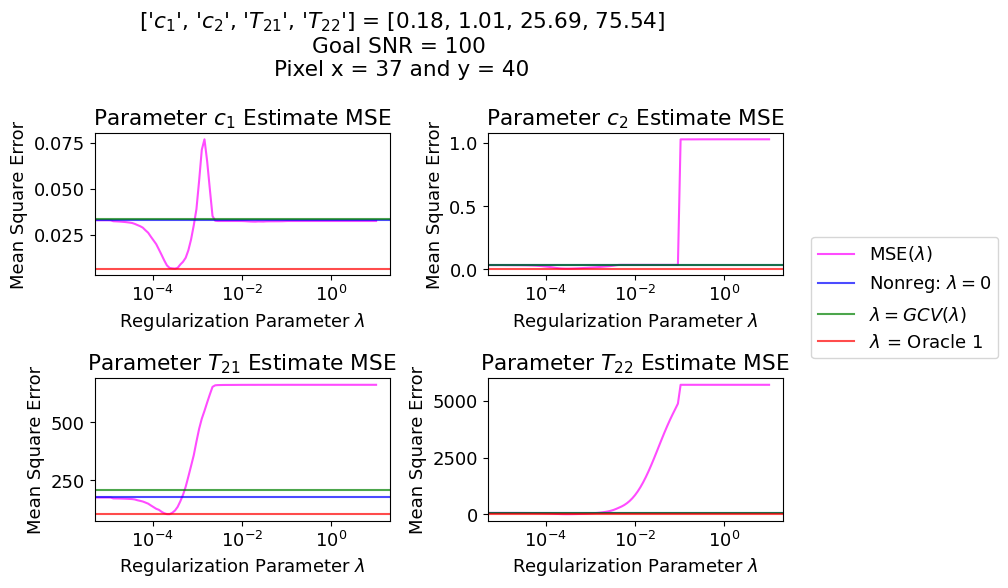

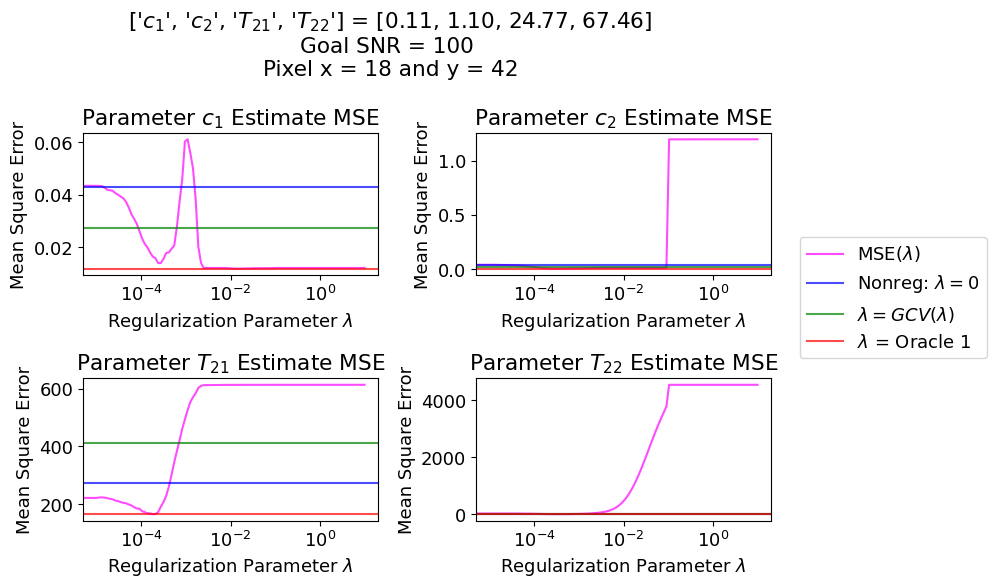

In [142]:
pixel_test = [0,1,2,3]



for pix in pixel_test:
    single_pC_GCV_MSE = GCV_MSE[pix,:]
    single_pC_orcAvg = orcAvg_MSE[pix,:,:]
    single_pC_orcAvg_min = np.min(single_pC_orcAvg, axis = 0)
    # single_pC_orcErr = minErr_agg_MSE[pC_index,:]
    single_pC_nonReg = nonreg_MSE[pix,:]

    # CRLB_unbiased = cov_matrix(*, SNR_option)

    plt.rc('font', size = 13)
    fig, ax = plt.subplots(2,2, figsize=(8,6), tight_layout=True)
    # fig.suptitle(str(param_name_list) + str(pCombo_oi) + '\nSNR = ' + str(SNR_option) + post_norm_blurb)
    plt.suptitle(f"{param_name_list} = [{nonreg_sr_params[pix,0]:.2f}, {nonreg_sr_params[pix,1]:.2f}, {nonreg_sr_params[pix,2]:.2f}, {nonreg_sr_params[pix,3]:.2f}]" +
                 f"\nGoal SNR = {SNR_goal} {post_norm_blurb}\nPixel x = {pixels[pix,1]} and y = {pixels[pix,0]}")
    for i in range(4):
        ax[i//2, i%2].semilogx(lambdas, single_pC_orcAvg[:,i], label = r'MSE($\lambda$)', alpha = 0.7, color = "magenta")
        ax[i//2, i%2].axhline(y = single_pC_nonReg[i], label = r'Nonreg: $\lambda = 0$', alpha = 0.7, color = "blue")
        ax[i//2, i%2].axhline(y = single_pC_GCV_MSE[i], label = r'$\lambda = GCV(\lambda)$', alpha = 0.7, color = "green")
        ax[i//2, i%2].axhline(y = single_pC_orcAvg_min[i], label = r'$\lambda$ = Oracle 1', alpha = 0.7, color = "red")
        # ax[i//2, i%2].axhline(y = single_pC_orcErr[i], label = r'$\lambda$ = Oracle 2', alpha = 0.7, color = "orange")
        # ax[i//2, i%2].axhline(y = CRLB_unbiased[i,i], label = r'unbiased CRLB', alpha = 0.7, color = "black")
        ax[i//2, i%2].set_xlabel(r'Regularization Parameter $\lambda$')
        ax[i//2, i%2].set_ylabel('Mean Square Error')
        ax[i//2, i%2].set_title(f"Parameter {param_name_list[i]} Estimate MSE")
    handles, labels = ax[1,1].get_legend_handles_labels()
    fig.legend(handles, labels, loc = 'center left', bbox_to_anchor = (1,0.5))
    plt.show()